In [1]:
import numpy as np
import pandas as pd
import re, pickle, os
import tensorflow as tf
import matplotlib.pyplot as plt
from scrape import get_entire_web_google_results

# PART 01

### CONCLUSION GENERATION

In [2]:
def clean_dataset(file_dir):
    df = None
    for file in os.listdir(file_dir):
        if file.endswith(".csv"):
            if df is None:
                df = pd.read_csv(file_dir + file)
                df = df[['Paragraph', 'Conclusion']]
                df = df.dropna()
            else:
                df = df.append(pd.read_csv(file_dir + file))
    
    df = df.dropna(how='any', axis=0)
    df['Paragraph'] = df['Paragraph'].apply(lambda x : x.lower().strip())
    df['Conclusion'] = df['Conclusion'].apply(lambda x : 'sostok '+ x + ' eostok')

    paragraphs = df['Paragraph'].tolist()
    conclusions = df['Conclusion'].tolist()

    return paragraphs, conclusions

def plot_token_length_distribution(paragraphs, conclusions):
    paragraph_lengths = [len(paragraph.split()) for paragraph in paragraphs]
    conclusion_lengths = [len(conclusion.split()) for conclusion in conclusions]

    plt.figure(figsize=(16, 8))
    
    plt.subplot(1, 2, 1)
    plt.hist(paragraph_lengths, bins=50)
    plt.xlabel('paragraph Length')
    plt.ylabel('Number of paragraphs')
    plt.title('paragraph Length Distribution')

    plt.subplot(1, 2, 2)
    plt.hist(conclusion_lengths, bins=50)
    plt.xlabel('conclusion Length')
    plt.ylabel('Number of conclusions')
    plt.title('conclusion Length Distribution')

    plt.show()

    b = [i for i in range(90,100)] 
    for i in b:  
        print(i,'th percentile [paragraphS] is ', np.percentile(paragraph_lengths, i))

    print('\n')

    for i in b:
        print(i,'th percentile [conclusions] is ', np.percentile(conclusion_lengths, i))

def get_tokenizer(
                paragraphs, 
                conclusions,
                save_path1,
                save_path2
                ):

    tokenizer1 = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer1.fit_on_texts(paragraphs)

    with open(save_path1, 'wb') as handle:
        pickle.dump(tokenizer1, handle, protocol=pickle.HIGHEST_PROTOCOL)

    tokenizer2 = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer2.fit_on_texts(conclusions)

    with open(save_path2, 'wb') as handle:
        pickle.dump(tokenizer2, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return tokenizer1, tokenizer2

def process_dataset(
                    file_dir,
                    tokenizer_path_paragraphs,
                    tokenizer_path_conclusions,
                    max_length_paragraph = 500,
                    max_length_conclusion = 150
                    ):
    paragraphs, conclusions = clean_dataset(file_dir)
    plot_token_length_distribution(paragraphs, conclusions)

    tokenizer_paragraphs, tokenizer_summarize = get_tokenizer(paragraphs, conclusions, tokenizer_path_paragraphs, tokenizer_path_conclusions)

    paragraphs = tokenizer_paragraphs.texts_to_sequences(paragraphs) 
    conclusions = tokenizer_summarize.texts_to_sequences(conclusions)

    paragraphs = tf.keras.preprocessing.sequence.pad_sequences(paragraphs, maxlen=max_length_paragraph, padding='post')
    conclusions = tf.keras.preprocessing.sequence.pad_sequences(conclusions, maxlen=max_length_conclusion, padding='post')

    return paragraphs, conclusions, tokenizer_paragraphs, tokenizer_summarize

C:\Users\Hesh m ra\AppData\Local\Temp\ipykernel_16904\1797763986.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(file_dir + file))
C:\Users\Hesh m ra\AppData\Local\Temp\ipykernel_16904\1797763986.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(file_dir + file))


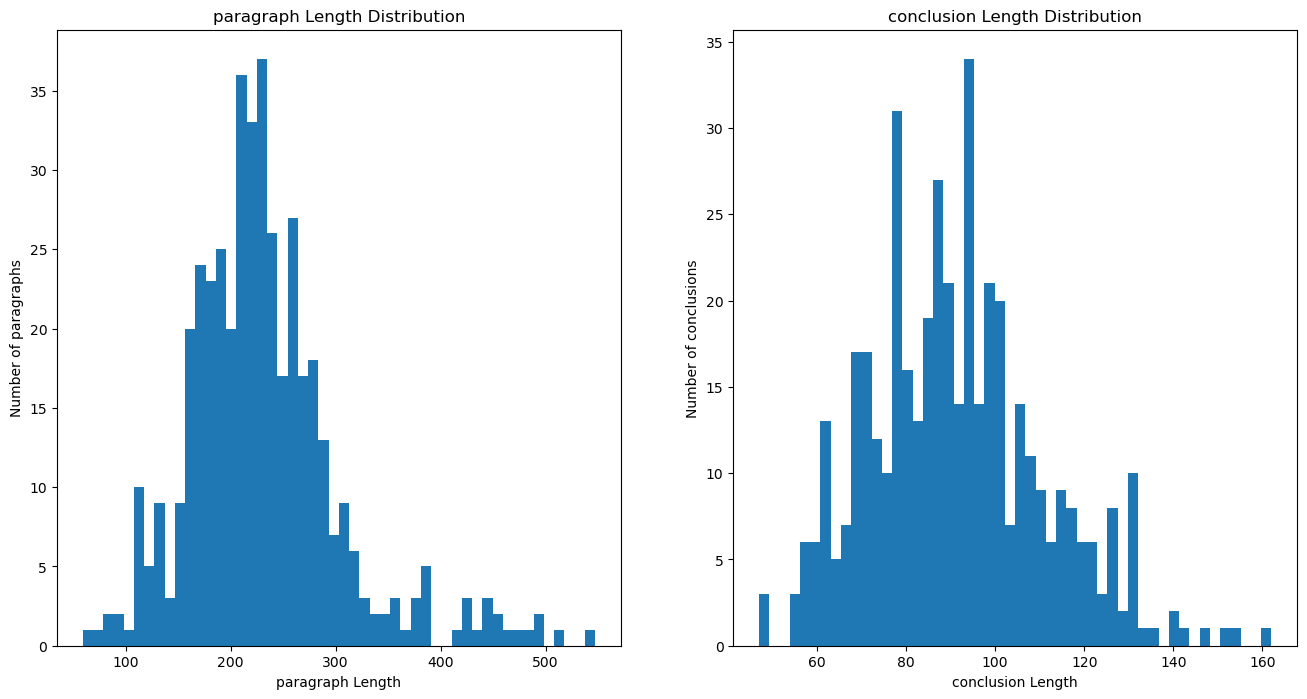

90 th percentile [paragraphS] is  310.40000000000003
91 th percentile [paragraphS] is  314.76
92 th percentile [paragraphS] is  323.36
93 th percentile [paragraphS] is  343.7600000000002
94 th percentile [paragraphS] is  360.03999999999985
95 th percentile [paragraphS] is  379.79999999999995
96 th percentile [paragraphS] is  389.12
97 th percentile [paragraphS] is  424.76000000000005
98 th percentile [paragraphS] is  449.67999999999984
99 th percentile [paragraphS] is  479.2399999999998


90 th percentile [conclusions] is  118.40000000000003
91 th percentile [conclusions] is  120.0
92 th percentile [conclusions] is  121.12
93 th percentile [conclusions] is  123.0
94 th percentile [conclusions] is  126.0
95 th percentile [conclusions] is  127.0
96 th percentile [conclusions] is  130.0
97 th percentile [conclusions] is  130.0
98 th percentile [conclusions] is  132.55999999999995
99 th percentile [conclusions] is  142.27999999999997


(array([[  50,    8,    5, ...,    0,    0,    0],
        [ 674,  183,    1, ...,    0,    0,    0],
        [  12, 1137,  102, ...,    0,    0,    0],
        ...,
        [ 578,  608, 1332, ...,    0,    0,    0],
        [   5,  587,   87, ...,    0,    0,    0],
        [ 235,  454,    1, ...,    0,    0,    0]]),
 array([[  12,   37,    8, ...,    0,    0,    0],
        [  12,  343,  153, ...,    0,    0,    0],
        [  12,    2, 2179, ...,    0,    0,    0],
        ...,
        [  12,    6,   24, ...,    0,    0,    0],
        [  12,    6,   24, ...,    0,    0,    0],
        [  12,    6,   24, ...,    0,    0,    0]]),
 <keras.preprocessing.text.Tokenizer at 0x201b2f01640>)

In [4]:
process_dataset(
            'data/conclusion/',
            'weights/conclusion/TOKENIZER_FACTS_MODEL_PARAGRAPHS.pkl',
            'weights/conclusion/TOKENIZER_FACTS_MODEL_CONCLUTIONS.pkl',
            )

In [5]:
def encoder(max_x_len, x_voc_size):
    encoder_inputs = tf.keras.layers.Input(shape=(max_x_len,))
    enc_emb = tf.keras.layers.Embedding(x_voc_size, 300, mask_zero=True)(encoder_inputs)
    encoder_lstm = tf.keras.layers.LSTM(300, return_sequences=True, return_state=True)
    encoder_output, state_h, state_c = encoder_lstm(enc_emb)
    encoder_states = [state_h, state_c]
    return encoder_inputs, encoder_states

def decoder(max_y_len, y_voc_size, encoder_states):
    decoder_inputs = tf.keras.layers.Input(shape=(None,))
    dec_emb_layer = tf.keras.layers.Embedding(y_voc_size, 300, mask_zero=True)
    dec_emb = dec_emb_layer(decoder_inputs)
    decoder_lstm = tf.keras.layers.LSTM(300, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
    decoder_dense = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(y_voc_size, activation='softmax'))
    decoder_outputs = decoder_dense(decoder_outputs)
    return decoder_inputs, decoder_outputs

def seq2seq(max_x_len, x_voc_size, max_y_len, y_voc_size):
    encoder_inputs, encoder_states = encoder(max_x_len, x_voc_size)
    decoder_inputs, decoder_outputs = decoder(max_y_len, y_voc_size, encoder_states)
    model = tf.keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)
    return model


def train(                   
        file_dir,
        tokenizer_path_paragraphs,
        tokenizer_path_conclusions,
        summarization_model_path
        ):
    
    paragraphs, conclusions, tokenizer_paragraphs, tokenizer_summarize = process_dataset(file_dir, tokenizer_path_paragraphs, tokenizer_path_conclusions)
    max_x_len = paragraphs.shape[1]
    max_y_len = conclusions.shape[1]
    x_voc_size = len(tokenizer_paragraphs.word_index) + 1
    y_voc_size = len(tokenizer_summarize.word_index) + 1

    model = seq2seq(max_x_len, x_voc_size, max_y_len, y_voc_size)

    call_bactks = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights=True)

    model.compile(
                optimizer='adam', 
                loss='categorical_crossentropy',
                metrics=[
                        'accuracy',
                        tf.keras.metrics.Precision(),
                        tf.keras.metrics.Recall(),
                        tf.keras.metrics.AUC()
                        ])
    model.summary()

    model.fit(
            [paragraphs, conclusions[:,:-1]], 
            tf.keras.utils.to_categorical(conclusions.reshape(conclusions.shape[0], conclusions.shape[1], 1)[:,1:]), 
            batch_size=12, 
            epochs=1000,
            callbacks=[call_bactks]
            )
    
    model.save(summarization_model_path)

C:\Users\Hesh m ra\AppData\Local\Temp\ipykernel_16904\1797763986.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(file_dir + file))
C:\Users\Hesh m ra\AppData\Local\Temp\ipykernel_16904\1797763986.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.read_csv(file_dir + file))


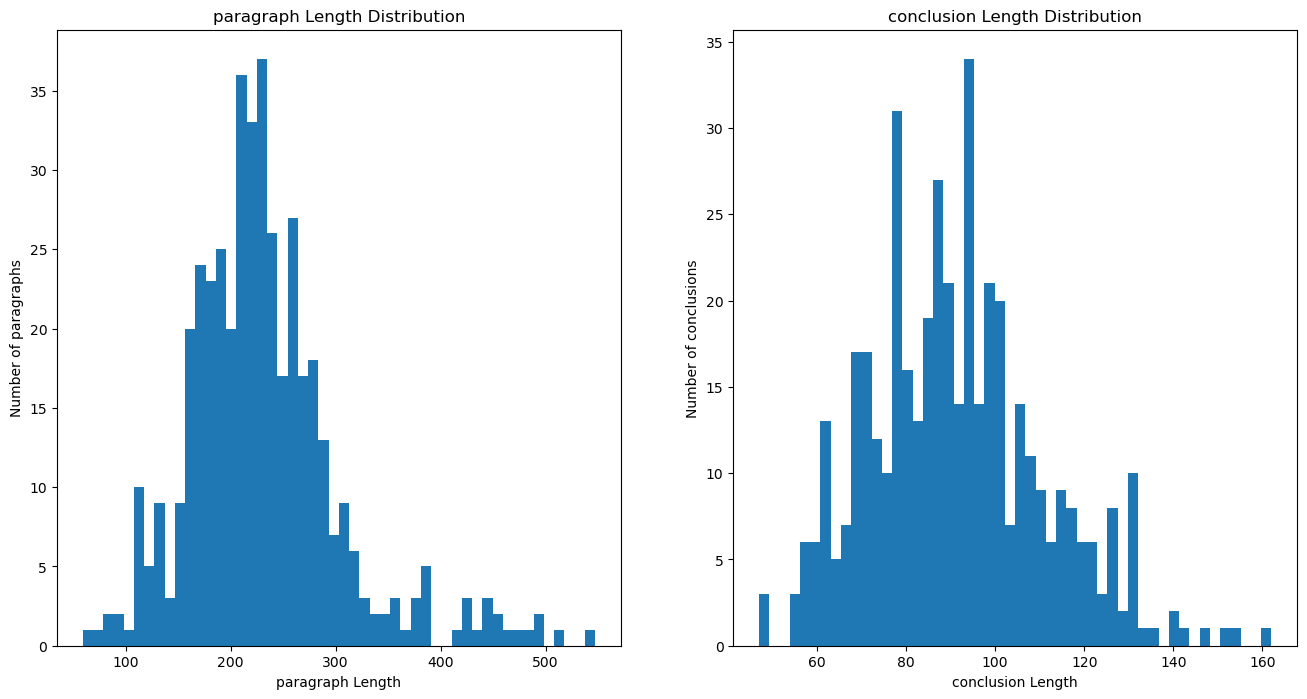

90 th percentile [paragraphS] is  310.40000000000003
91 th percentile [paragraphS] is  314.76
92 th percentile [paragraphS] is  323.36
93 th percentile [paragraphS] is  343.7600000000002
94 th percentile [paragraphS] is  360.03999999999985
95 th percentile [paragraphS] is  379.79999999999995
96 th percentile [paragraphS] is  389.12
97 th percentile [paragraphS] is  424.76000000000005
98 th percentile [paragraphS] is  449.67999999999984
99 th percentile [paragraphS] is  479.2399999999998


90 th percentile [conclusions] is  118.40000000000003
91 th percentile [conclusions] is  120.0
92 th percentile [conclusions] is  121.12
93 th percentile [conclusions] is  123.0
94 th percentile [conclusions] is  126.0
95 th percentile [conclusions] is  127.0
96 th percentile [conclusions] is  130.0
97 th percentile [conclusions] is  130.0
98 th percentile [conclusions] is  132.55999999999995
99 th percentile [conclusions] is  142.27999999999997
Model: "model"
_________________________________________

In [ ]:
train(
    'data/conclusion/',
    'weights/conclusion/TOKENIZER_FACTS_MODEL_PARAGRAPHS.pkl',
    'weights/conclusion/TOKENIZER_FACTS_MODEL_CONCLUTIONS.pkl',
    'weights/conclusion/CONCLUTION_GENERATION_MODEL.h5'
    )

# INFERENCE

In [ ]:
text = '''
"Jaykay Marketing Services (Pvt) Limited, part of the Keells Holdings PLC conglomerate, introduced the Keells Super to the Sri Lankan supermarket chain in 1991 by opening doors to the market as a new concept. Jaykay Marketing Services (Pvt) Limited is owned by huge companies in a variety of industries. Jaykay Marketing Services (Pvt.) Limited, which opened Keells Super's first location in Liberty Plaza, now has 109 locations all over the island, expanding the supply chain.
The organization's essential providers included market pioneers like Ceylon Biscuits Limited and Unilever Sri Lanka Limited. Ceylon Colds Stores PLC, the parent company of Keells Supermarket, and Keells Food Products PLC, a related entity, are also Keells Supermarket's direct suppliers. However, when organic and own-label products were introduced, medium-sized suppliers and farmers joined the JMSL in sourcing.
At first, Keells Super's primary business was the sale of a wide range of goods, primarily FMCG (fast-moving consumer goods), such as groceries, household goods, and other necessities that could satisfy the requirements of customers of the time. In 2000, a market trend prompted the development of the Nexus Mobile Loyalty Card system. Each bill received points that could be used later. Every supermarket began to provide payment options for utility bills and prescriptions over time.
However, in order to meet the ever-increasing needs of its customers and keep up with market trends, the company opened its own bakery in there supermarkets, which led to an increase in sales. And in line with the general trend in the market, Jaykay Marketing Services (Pvt.) In December 2000, Limited introduced the Nexus Loyalty program with a points system that allowed customers to later redeem their bills, strengthening their relationship with Keells Supermarket.
""Our passion is to deliver pleasure and nutrition throughout people's lives, through exciting and superior products, whenever and wherever they choose to eat and drink,"" is the vision that they have passionate to make a quality difference in the world.
Under the group practices of Jaykay Marketing Services (Pvt.) Limited it recreate it`s goals and objectives once every 5 years to meet the customers` needs and ultimately to ensure the success of the business process. As part of the company's effort to increase revenue, Keells supermarket owns over 300 products under its own brand name, ""K Choice."" "
'''

In [ ]:
tokenizer_path_paragraphs = 'weights/conclusion/TOKENIZER_FACTS_MODEL_PARAGRAPHS.pkl'
tokenizer_path_conclusions = 'weights/conclusion/TOKENIZER_FACTS_MODEL_CONCLUTIONS.pkl'
conclution_generation_model_path = 'weights/conclusion/CONCLUTION_GENERATION_MODEL.h5'

with open(tokenizer_path_paragraphs, 'rb') as handle:
    tokenizer_paragraphs = pickle.load(handle)

with open(tokenizer_path_conclusions, 'rb') as handle:
    tokenizer_conclusions = pickle.load(handle)

encoder_inputs, encoder_states = encoder(500, len(tokenizer_paragraphs.word_index) + 1)
decoder_inputs, decoder_outputs = decoder(150, len(tokenizer_conclusions.word_index) + 1, encoder_states)
inference_model = tf.keras.models.Model([encoder_inputs, decoder_inputs], decoder_outputs)
inference_model.load_weights(conclution_generation_model_path)

In [ ]:
def inference_conclution_generation(
                                    input_text,
                                    max_x_len = 500,
                                    max_y_len = 150
                                    ):

    input_text = tokenizer_paragraphs.texts_to_sequences([input_text])
    input_text = tf.keras.preprocessing.sequence.pad_sequences(input_text, maxlen=max_x_len, padding='post')

    conclusion = np.zeros((1, max_y_len))
    conclusion[0,0] = tokenizer_conclusions.word_index['sostok']
    stop_condition = False
    i = 1
    while not stop_condition:
        preds = inference_model.predict([input_text, conclusion], verbose=0)
        pred = np.argmax(preds[0,i-1])
        conclusion[0,i] = pred
        i += 1
        if pred == tokenizer_conclusions.word_index['eostok'] or i >= max_y_len:
            stop_condition = True

    conclusion = conclusion[0]
    new_conclusion = []
    for i in conclusion:
        if i != 0:
            new_conclusion.append(i)
    conclusion = ' '.join([tokenizer_conclusions.index_word[i] for i in new_conclusion])
    conclusion = conclusion.replace('eostok', '').replace('sostok', '').strip()
    return conclusion

In [ ]:
conclusion_facts = inference_conclution_generation(text)
conclusion_facts

# PART 02

### Image Scraping

In [ ]:
def scraping_references(search_item):
    df = get_entire_web_google_results(search_item)
    image_urls = df['image_url'].tolist()
    image_urls = [i for i in image_urls if i != '']
    image_urls = [i for i in image_urls if 'logo' not in i]
    return image_urls

In [ ]:
search_item = '''A printer is a device that produces text and graphics on paper or other materials. There are several types of printers available, including inkjet printers, laser printers, and thermal printers. Inkjet printers are popular for home use, while laser printers are commonly used in offices due to their speed and durability. Thermal printers are commonly used for printing receipts or shipping labels. Printers can be connected to computers, mobile devices, or network servers, and can be used to print a wide range of documents, including photos, reports, and marketing materials. Advances in printer technology have led to increased efficiency and lower costs, making them a crucial tool in modern business and personal use.'''
image_urls = scraping_references(search_item)
image_urls